### Freefire and Pub G visualization

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import datetime

In [202]:
#load data
data = pd.read_excel("freefireandpub_g.xlsx")
data.info()
data = data.dropna()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Created date    547 non-null    datetime64[ns]
 1   Created time    547 non-null    datetime64[ns]
 2   Name (Profile)  547 non-null    object        
 3   Post ID         547 non-null    object        
 4   Post type       547 non-null    object        
 5   Content type    544 non-null    object        
 6   Message         535 non-null    object        
 7   Link to post    547 non-null    object        
 8   Posts           547 non-null    int64         
 9   Likes           547 non-null    int64         
 10  Reactions       547 non-null    int64         
 11  Comments        547 non-null    int64         
 12  Post shares     530 non-null    float64       
 13  Likes per post  547 non-null    int64         
 14  WEEKNUM         547 non-null    int64         
 15  HOUR  

### Define problem
1.   Which game is popular, which type of post get *the* like or engagement.
2.   Which post that people like the post.(Top 5)
3.   What time that the page is like to post.
4.   Are people read, like, share the post that have long text. 
5.   Relationship between like Vs post share.
6.   Classify page content => promotion or not
7.   Weekly and monthly data(trend)


### 1. Which game is popular, which type of post get *the* like or engagement.




In [203]:
freefire_sum = data[['Likes','Post shares','Comments','Reactions']][data['Name (Profile)'] == 'Garena Free Fire'].sum(axis=0) 
freefire_mean = data[['Likes','Post shares','Comments','Reactions']][data['Name (Profile)'] == 'Garena Free Fire'].mean(axis=0) 
pubg_sum = data[['Likes','Post shares','Comments','Reactions']][data['Name (Profile)'] == 'PUBG: BATTLEGROUNDS'].sum(axis=0)
pubg_mean = data[['Likes','Post shares','Comments','Reactions']][data['Name (Profile)'] == 'PUBG: BATTLEGROUNDS'].mean(axis=0)
print(f"Sum of freefire\n {freefire_sum}\n\nAverage of freefire\n {freefire_mean}\n\nSum of pub g\n {pubg_sum}\n\nAverage of pub g\n {pubg_mean}\n")

Sum of freefire
 Likes          1013185.0
Post shares      34893.0
Comments         72768.0
Reactions      1161397.0
dtype: float64

Average of freefire
 Likes          3518.003472
Post shares     121.156250
Comments        252.666667
Reactions      4032.628472
dtype: float64

Sum of pub g
 Likes          248134.0
Post shares     14300.0
Comments         8320.0
Reactions      261237.0
dtype: float64

Average of pub g
 Likes          1074.173160
Post shares      61.904762
Comments         36.017316
Reactions      1130.896104
dtype: float64



In [204]:
#Engagement
print(f"So the Engagement of Freefire is {freefire_sum.sum(0)} and Pub_G is {pubg_sum.sum(0)}. Now we can see that is freefire popular more than pubg?")

So the Engagement of Freefire is 2282243.0 and Pub_G is 531991.0. Now we can see that is freefire popular more than pubg?


### 2. Which post that people like the post.(Top 5)

In [206]:
data[['Name (Profile)','Message','Content type','Post shares']].sort_values('Post shares',ascending=False).head(5)

,Name (Profile),Message,Content type,Post shares
114,Garena Free Fire,ปองกนไวกอนกบบญชของ facebook \nชวงนมเรองของ fac...,album,2895.0
218,Garena Free Fire,รวมไอเทมโดนใจ สงทาย booyah day \n4 วนรวด ทจดไอ...,photo,2666.0
165,Garena Free Fire,โปรเดด free fire 1111 \nจดหนก จดเตมกบของเดดไมซ...,photo,2028.0
63,Garena Free Fire,โหมดใหม ทจะมาสรางความเราใจ \nลนระทกทกฝกาว \nเ...,photo,1884.0
220,Garena Free Fire,อปเดตแพทซใหม บาลานซกวาเดม \nเตรยมปรบตวกนไวใหด ...,album,1129.0


### 3. What time that the page is like to post.

The graph shows that Facebook page post most frequently at 3:00 p.m., followed by 8:00, 13:00, and 20:00,
 which correspond to people's free times, such as before work, at lunch, or after work, etc.
the yellow point show that the 'PROMOTION' is post in interval time


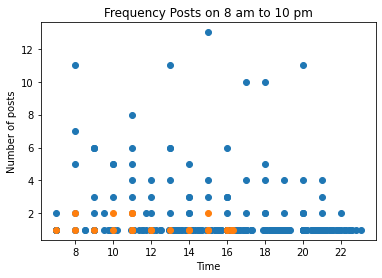

In [239]:
d = pd.to_datetime(data['Created time']).dt.time.reset_index()
d = d['Created time'].value_counts().to_frame().reset_index()
times = d['index']
hours = times.apply(lambda x: x.hour)
minutes = times.apply(lambda x: x.minute)
time_floats = hours + minutes/60

plt.scatter(time_floats,d['Created time'])
plt.xlabel('date')
plt.ylabel('count')
plt.show
print(f"The graph shows that Facebook page post most frequently at 3:00 p.m., followed by 8:00, 13:00, and 20:00,\n which correspond to people's free times, such as before work, at lunch, or after work, etc.")

d = pd.to_datetime(data['Created time'][data["PROMOTION"] == 1]).dt.time.reset_index()
d = d['Created time'].value_counts().to_frame().reset_index()
times = d['index']
hours = times.apply(lambda x: x.hour)
minutes = times.apply(lambda x: x.minute)
time_floats = hours + minutes/60

plt.scatter(time_floats,d['Created time'])
plt.title("Frequency Posts on 8 am to 10 pm")
plt.xlabel('Time')
plt.ylabel('Number of posts')
plt.show
print(f"the yellow point show that the 'PROMOTION' is post in interval time")

### 4. Are people read, like, share the post that have long text.

In [208]:
data['long'] = data['Message'].str.len()
data['engage'] = data['Likes']+data['Post shares']+data['Comments']+data['Reactions']
engage = data[['Name (Profile)','Message','long','Content type','Likes','Post shares','Comments','Reactions','engage']].sort_values('long',ascending=False)
print(f"Again that the data analyze help has to know the insight from data.\nWe can see that the long text post in not gain interest from people,\nIn the otherhand less text information with video or photo has more interest than long text post ")
engage

Again that the data analyze help has to know the insight from data.
We can see that the long text post in not gain interest from people,
In the otherhand less text information with video or photo has more interest than long text post 


,Name (Profile),Message,long,Content type,Likes,Post shares,Comments,Reactions,engage
469,PUBG: BATTLEGROUNDS,pgc2021 playbook ep1 ยอนดแผนการเลนของ oath ในเ...,1765,video_inline,128,3.0,2,129,262.0
433,PUBG: BATTLEGROUNDS,pgc moments 1 รวมชอทเฟยวปนลนทง จากการแขงขนพบจช...,1738,video_inline,438,16.0,3,451,908.0
447,PUBG: BATTLEGROUNDS,pgc2021 ศกพบจชงแชมปโลก รวมพล 32 ทมทดทสดในโลก ช...,1606,video_inline,562,31.0,1,572,1166.0
453,PUBG: BATTLEGROUNDS,pgc2021 rivals ep1 คมเฉอนคมนอกจอ เมอ pio vs tg...,1535,video_inline,186,10.0,0,190,386.0
458,PUBG: BATTLEGROUNDS,อพเดทการแขงขนพบจชงแชมปโลก ในรายการ weekly pgc2...,1529,video_inline,133,7.0,0,135,275.0
...,...,...,...,...,...,...,...,...,...
7,Garena Free Fire,animation จากโรงงานราง สสมรภม\nเอาชวตรอดและชงค...,81,video,1969,90.0,158,2168,4385.0
242,Garena Free Fire,survivals master winter \nเสนทางสโปรลกกำลงจะเร...,75,photo,697,111.0,40,733,1581.0
418,PUBG: BATTLEGROUNDS,𝐏𝐆𝐂𝟐𝟎𝟐𝟏 𝐒𝐂𝐎𝐏𝐄 พาบกกองงาน media day อยางหลออยาง...,71,share,224,3.0,1,227,455.0
156,Garena Free Fire,free fire showoff ซอมกบโปร kog และ syz ตวแทนป...,66,video_inline,925,59.0,240,1080,2304.0


### 5. Relationship between like Vs post share.

correlation between Post shares and Likes
                 Likes  Post shares
Likes        1.000000     0.344208
Post shares  0.344208     1.000000


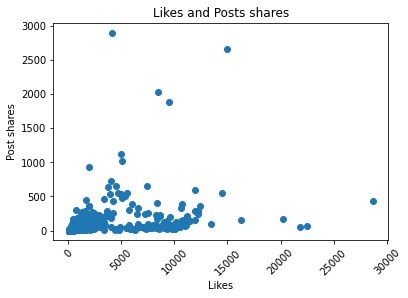

In [237]:
plt.scatter(data['Likes'],data['Post shares'])
plt.xticks(rotation=45)
plt.title("Likes and Posts shares")
plt.xlabel('Likes')
plt.ylabel('Post shares')
plt.show
print(f"correlation between Post shares and Likes\n {data[['Likes','Post shares']].corr()}")

### 6.Classify page content => promotion or not

In [222]:
# let try some text classification
df = data
df['Message'] = df['Message'].str.replace('[^\w\s]','')
df['Message'] = df['Message'].str.lower()
df['Message'] = df['Message'].str.strip()

#print(df['Message'].count())

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['PROMOTION'], test_size=0.3, random_state=42)

# Convert the text data into numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train a Naive Bayes classifier on the training data
clf = MultinomialNB()
clf.fit(X_train_vectors, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_vectors)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {round(accuracy*100,2)} %")
print("Anyway this model can't be trusted because the data is not balance for use in modeling.")

Accuracy : 97.44 %
Anyway this model can't be trusted because the data is not balance for use in modeling.


<ipython-input-222-6cc312733678>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Message'] = df['Message'].str.replace('[^\w\s]','')


### 7. Weekly and monthly data(trend)

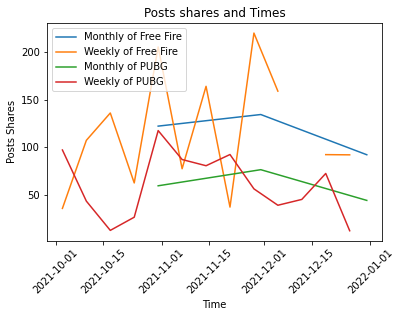

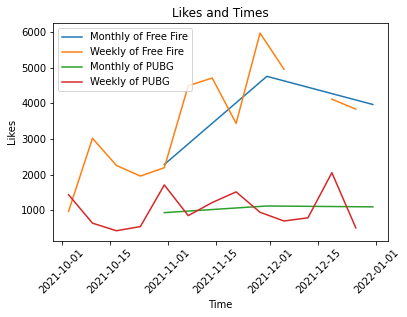

In [236]:
#post shares
df = data[['Created date','Post shares']][data['Name (Profile)'] == 'Garena Free Fire']
df1 = data[['Created date','Post shares']][data['Name (Profile)'] == 'PUBG: BATTLEGROUNDS']

monthly_data = df.set_index('Created date').resample('M').mean()
weekly_data = df.set_index('Created date').resample('W').mean()

monthly_data1 = df1.set_index('Created date').resample('M').mean()
weekly_data1 = df1.set_index('Created date').resample('W').mean()

# Plot the data using matplotlib
#freefire
plt.plot(monthly_data, label='Monthly of Free Fire')
plt.plot(weekly_data, label='Weekly of Free Fire')
#pubg
plt.plot(monthly_data1, label='Monthly of PUBG')
plt.plot(weekly_data1, label='Weekly of PUBG')

# Add labels and legend to the plot
plt.title("Posts shares and Times")
plt.xlabel('Time')
plt.ylabel('Posts Shares')
plt.xticks(rotation=45)
plt.legend(loc='best')

# Show the plot
plt.show()
#========================================================================================
#Likes
df = data[['Created date','Likes']][data['Name (Profile)'] == 'Garena Free Fire']
df1 = data[['Created date','Likes']][data['Name (Profile)'] == 'PUBG: BATTLEGROUNDS']

monthly_data = df.set_index('Created date').resample('M').mean()
weekly_data = df.set_index('Created date').resample('W').mean()

monthly_data1 = df1.set_index('Created date').resample('M').mean()
weekly_data1 = df1.set_index('Created date').resample('W').mean()

# Plot the data using matplotlib
#freefire
plt.plot(monthly_data, label='Monthly of Free Fire')
plt.plot(weekly_data, label='Weekly of Free Fire')
#pubg
plt.plot(monthly_data1, label='Monthly of PUBG')
plt.plot(weekly_data1, label='Weekly of PUBG')

# Add labels and legend to the plot
plt.title("Likes and Times")
plt.xlabel('Time')
plt.ylabel('Likes')
plt.xticks(rotation=45)
plt.legend(loc='best')

# Show the plot
plt.show()
